<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

**1.1 Загрузка библиотек и глобальных переменных.**

In [60]:
import pandas as pd 
import numpy as np 

from tqdm import tqdm
from tqdm.notebook import tqdm


import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 
import re 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 12345

**1.2 Пользовательские функции.**

In [2]:
# Напишем функцию для первичной проверки данных

def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())


**1.3 Загрузим данные:**

In [3]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [4]:
df.sample(n=5)

,text,toxic
131205,"heads up, there was a good revertion you remov...",0
123337,Apparently I wasn't clear enough the first tim...,1
129575,I fully agree with Lupo. I have given him full...,0
148371,"""\n\nFebruary 2006\n\nPlease stop adding nonse...",0
50832,"RFCU \n\nFYI, I have opened Wikipedia:Requests...",0


**1.4 Первичный осмотр данных.** \
Описательный анализ:

In [5]:
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None
(159292, 2)

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Исследуем баланс классов:

0    0.898388
1    0.101612
Name: toxic, dtype: float64


<AxesSubplot:title={'center':'Частота класса'}>

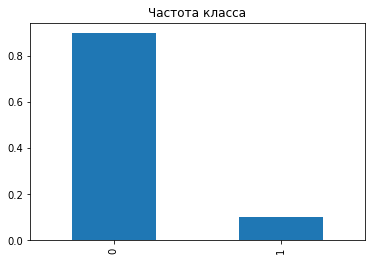

In [6]:
class_frequency = df['toxic'].value_counts(normalize=bool)
print(class_frequency)
class_frequency.plot(kind='bar', title='Частота класса')

**Вывод:**
- в таблице 159292 срок и 2 столбца:
- пропусков нет;
- дубликатов нет;
- наблюдаем дисбаланс классов.

Напишем функцию очистки текста от лишних символов:

In [7]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

In [8]:
tqdm.pandas()
df['text'] = df['text'].progress_apply(clear_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [9]:
df

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159446,and for the second time of asking when your vi...,0
159447,you should be ashamed of yourself that is a ho...,0
159448,spitzer umm theres no actual article for prost...,0
159449,and it looks like it was actually you who put ...,0


Напишем функцию РОS-тэгирования слов:

In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               
                "N": wordnet.NOUN,              
                "V": wordnet.VERB,              
                "R": wordnet.ADV                
               }  
    return tag_dict.get(tag, wordnet.NOUN)


Напишем функцию лемматизации:

In [11]:
lemmatizer = WordNetLemmatizer()

def lemm_text(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)

In [13]:
!pip install pandarallel
from pandarallel import pandarallel   
tqdm.pandas(desc="progress")
pandarallel.initialize(progress_bar = True)

     |████████████████████████████████| 110 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 282 kB 15.3 MB/s eta 0:00:01
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16679 sha256=be9a49f60da82a3352ae9da0ab048dc92892eda82174fe7dbb6de4a2ba82aae0
  Stored in directory: /home/jovyan/.cache/pip/wheels/39/fe/8d/f7912d85b21ea72c9a8a3fefa6141fab92e575a67ab17c4474
Successfully built pandarallel
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
nltk.download('averaged_perceptron_tagger')
df['text'] = df['text'].progress_apply(lemm_text)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


  0%|          | 0/159292 [00:00<?, ?it/s]

In [8]:
df['lemm_text'] = df['text'].apply(lemmatize)

In [13]:
df

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0
...,...,...
159446,and for the second time of ask when your view ...,0
159447,you should be ashamed of yourself that be a ho...,0
159448,spitzer umm there no actual article for prosti...,0
159449,and it look like it be actually you who put on...,0


Формируем фичи и целевую:

In [14]:
features = df['text']
target = df['toxic']

Разделим данные на обучающую и тестовую выборки:

In [15]:
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.1, 
                                                    random_state = RANDOM_STATE)

In [16]:
x_train.shape[0], y_train.shape[0], x_test.shape[0], y_test.shape[0]

(143362, 143362, 15930, 15930)

Очистим текст от стоп-слов:

In [18]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TF-IDF для обучающей выборки:

In [19]:
count_tf_idf_train = TfidfVectorizer(stop_words=stopwords) 
x_train = count_tf_idf_train.fit_transform(x_train) 
x_train.shape

(143362, 142204)

TF-IDF для тестовой выборки:

In [20]:
count_tf_idf_test = TfidfVectorizer(stop_words=stopwords)
x_test = count_tf_idf_train.transform(x_test)
x_test.shape

(15930, 142204)

**Вывод:**
- произведена лемматизация и очистка текста от лишних символов;
- разделены данные на обучающую (90%) и тестовую (10%) выборки;
- удалены стоп-слова;
- вычислены TF-IDF для текстов.

## Обучение

**2.1 LogisticRegression()**

In [21]:
# Обозначим модель

model_lr = LogisticRegression(random_state=RANDOM_STATE,
                              solver='liblinear')

# Зададим параметры
param_grid_lr = {'C': (0.1, 0.5, 1.0, 10),
                 'class_weight': (['balanced'])}

In [22]:
%%time

# Подберем гиперпараметры
grid_lr = RandomizedSearchCV(
    model_lr, param_grid_lr, scoring='f1', cv=3)

# Обучим модель  
model_lr = grid_lr.fit(x_train, y_train)

CPU times: user 1min 26s, sys: 1min 31s, total: 2min 57s
Wall time: 2min 58s


In [23]:
print(f'Лучшие параметры для LogisticRegression: ', model_lr.best_params_)
print(f'Значение метрики F1 для лучших параметров LogisticRegression: %.4f' % model_lr.best_score_)

Лучшие параметры для LogisticRegression:  {'class_weight': 'balanced', 'C': 10}
Значение метрики F1 для лучших параметров LogisticRegression: 0.7554


**2.2 Случайный лес.**

In [24]:
# Обозначим модель

model_rfc = RandomForestClassifier(random_state = RANDOM_STATE)

# Зададим параметры
param_grid_rfc = {'n_estimators': [10,100,10],
                  'max_depth': [4, 8, 2],
                  'min_samples_leaf': range(3,5),
                  'min_samples_split': range(2,6,2),
                  'class_weight': (['balanced'])}

In [25]:
%%time

# Подберем гиперпараметры
grid_rfc = RandomizedSearchCV(
    model_rfc, param_grid_rfc, scoring='f1', cv=3, 
    random_state=RANDOM_STATE)

# Обучим модель  
model_rfc = grid_rfc.fit(x_train, y_train)

CPU times: user 1min 35s, sys: 392 ms, total: 1min 35s
Wall time: 1min 35s


In [26]:
print(f'Лучшие параметры для RandomForestClassifier: ', model_rfc.best_params_)
print(f'Значение метрики F1 для лучших параметров RandomForestClassifier: %.4f' % model_rfc.best_score_)

Лучшие параметры для RandomForestClassifier:  {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4, 'class_weight': 'balanced'}
Значение метрики F1 для лучших параметров RandomForestClassifier: 0.3225


**2.3 SGDClassifier**

In [27]:
# Обозначим модель

model_sgdc = SGDClassifier(random_state = RANDOM_STATE)

# Зададим параметры
param_grid_sgdc = {'loss': ('hinge', 'log', 'modified_huber'),
                  'learning_rate': ('constant', 'optimal', 'invscaling', 'adaptive'),
                  'eta0': (.01, .05, .1, .5),
                  'class_weight': (['balanced'])}

In [28]:
%%time

# Подберем гиперпараметры
grid_sgdc = RandomizedSearchCV(model_sgdc,
                               param_grid_sgdc,
                               scoring='f1', 
                               cv=3, 
                               n_jobs=1)

# Обучим модель  
model_sgdc = grid_sgdc.fit(x_train, y_train)

CPU times: user 40 s, sys: 2.52 s, total: 42.5 s
Wall time: 42.8 s


In [29]:
print(f'Лучшие параметры для SGDClassifier: ', model_sgdc.best_params_)
print(f'Значение метрики F1 для лучших параметров SGDClassifier: %.4f' % model_sgdc.best_score_)

Лучшие параметры для SGDClassifier:  {'loss': 'modified_huber', 'learning_rate': 'adaptive', 'eta0': 0.01, 'class_weight': 'balanced'}
Значение метрики F1 для лучших параметров SGDClassifier: 0.7479


**2.4 DecisionTreeClassifier**

In [30]:
# Обозначим модель

model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
                                   
# Зададим параметры
param_grid_dtc = {'max_depth': ([x for x in range(10,51)]),
                  'class_weight': (['balanced'])}

In [31]:
%%time

# Подберем гиперпараметры
grid_dtc = RandomizedSearchCV(model_dtc,
                             param_grid_dtc,
                             cv=3,
                             scoring='f1')

# Обучим модель  
model_dtc = grid_dtc.fit(x_train, y_train)

CPU times: user 16min 47s, sys: 1.66 s, total: 16min 48s
Wall time: 16min 53s


In [32]:
print(f'Лучшие параметры для DecisionTreeClassifier: ', model_dtc.best_params_)
print(f'Значение метрики F1 для лучших параметров DecisionTreeClassifier: %.4f' % model_dtc.best_score_)

Лучшие параметры для DecisionTreeClassifier:  {'max_depth': 32, 'class_weight': 'balanced'}
Значение метрики F1 для лучших параметров DecisionTreeClassifier: 0.6393


In [33]:
from sklearn.pipeline import Pipeline


In [34]:
x_train_pipe, x_test_pipe, y_train_pipe, y_test_pipe = train_test_split(features,
                                                                        target,
                                                                        test_size=0.1, 
                                                                        random_state = RANDOM_STATE)

In [ ]:
%%time
text_clf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', LGBMClassifier(verbose=50, seed=RANDOM_STATE))])
    
param_grid_lgbm = {'vect__ngram_range': [(1, 1), (1, 2)],
                   'clf__iterations': ([200]),
                   'clf__class_weights':([(1, 1), (1, 11)])} 

model_lgbm = RandomizedSearchCV(text_clf, param_grid_lgbm, scoring='f1', cv=3, n_jobs=-1 )

model_lgbm.fit(x_train_pipe, y_train_pipe)

In [54]:
%%time

text_clf =Pipeline([('vect', TfidfVectorizer(stop_words='english')),
                     ('model', LGBMClassifier(verbose=50, 
                                              seed=RANDOM_STATE, 
                                              num_threads=1))])

param_grid_lgbm = {'model__class_weight': ['balanced']}                      

model_lgbm = RandomizedSearchCV(text_clf, param_grid_lgbm, scoring='f1', cv=3, n_jobs=-1 )

model_lgbm.fit(x_train_pipe, y_train_pipe)

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Info] Number of positive: 9716, number of negative: 85858
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.997470
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.997470
[LightGBM] [Debug] init for col-wise cost 16.475886 seconds, init for row-wise cost 16.462990 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 16.499575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 418286
[LightGBM] [Info] Number of data points in the train set: 95574, number of used features: 8192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initsc

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words='english')),
                                             ('model',
                                              LGBMClassifier(num_threads=1,
                                                             seed=12345,
                                                             verbose=50))]),
                   n_jobs=-1,
                   param_distributions={'model__class_weight': ['balanced']},
                   scoring='f1')

In [55]:
print(f'Лучшие параметры для LGBMClassifier: ', model_lgbm.best_params_)
print(f'Значение метрики F1 для лучших параметров LGBMClassifier: %.4f' % model_lgbm.best_score_)

Лучшие параметры для LGBMClassifier:  {'model__class_weight': 'balanced'}
Значение метрики F1 для лучших параметров LGBMClassifier: 0.7315


In [56]:
results = {
    'Model' : ['LogisticRegression', 
               'RandomForestClassifier',
               'SGDClassifier',
               'DecisionTreeClassifier',
               'LGBMClassifier'],
    'F1' :pd.Series([model_lr.best_score_, 
                     model_rfc.best_score_, 
                     model_sgdc.best_score_, 
                     model_dtc.best_score_,
                     model_lgbm.best_score_])}

display(pd.DataFrame(results))

,Model,F1
0,LogisticRegression,0.755382
1,RandomForestClassifier,0.322514
2,SGDClassifier,0.747916
3,DecisionTreeClassifier,0.639291
4,LGBMClassifier,0.731456


**Вывод:**
Лучший результат у _Логистической регрессии:_
- Лучшие параметры для LogisticRegression:  {'class_weight': 'balanced', 'C': 10}
- Значение метрики F1 для лучших параметров LogisticRegression: 0.7554

Проверим модель на тестовой выборке:

In [57]:
prediction = model_lr.predict(x_test)
result = f1_score(y_test, prediction)

print(f'Значение метрики F1 для лучшей модели: %.4f' % result)

Значение метрики F1 для лучшей модели: 0.7606


**Вывод:**
- значение метрики F1 для лучшей модели на тестовой выборке = **0.7606.**

Условие: \
значение метрики качества F1 не меньше 0.75 - выполнено.

Проверим модель на адекватность:

In [58]:
dummy_model = DummyClassifier(strategy = 'constant',
                              constant = 1, 
                              random_state=RANDOM_STATE)
dummy_model.fit(x_train, y_train)
dummy_result = f1_score(y_test, dummy_model.predict(x_test))

print(f'Значение метрики F1 для константной модели: %.4f' % dummy_result)

Значение метрики F1 для константной модели: 0.1838


**Вывод:** 
- модель адекватна.

## Выводы

1. **_Были подготовлены данные:_**
- в таблице 159292 срок и 2 столбца:
- пропусков нет;
- дубликатов нет;
- наблюдаем дисбаланс классов;
- произведена лемматизация и очистка текста от лишних символов;
- разделены данные на обучающую (90%) и тестовую (10%) выборки;
- удалены стоп-слова;
- вычислены TF-IDF для корпуса текстов.

2. **_Обучены модели:_** 
| Model | F1 | 
|---|---|
| LinearRegression | 0.755382 |
| RandomForest | 0.322514 | 
| SGDClassifier | 0.747916 | 
| DecisionTreeClassifier | 0.639291 |
| LGBMClassifier | 0.731456 |

3. **_Выбрана лучшая модель - _LogisticRegression_ и проверена на тестовой выборке:**
- Лучшие параметры для LogisticRegression:  {'class_weight': 'balanced', 'C': 10}
- Значение метрики F1 для лучших параметров LogisticRegression: 0.7554
- Значение метрики F1 для лучшей модели на тестовой выборке = **0.7606.**

Условие: \
значение метрики качества F1 не меньше 0.75 - выполнено.

4. **_Модель проверена на адекватность:_**
- Значение метрики F1 для константной модели: 0.1838 - **модель адкватна.**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны